Pull data from API here

PS: 
- given Bitcoin on-chain data, what are the factors that most affect price movement?
- What categories can be identified in the Bitcoin addresses/wallets? (use clustering technique)


Dataset: APIs from Glassnode, Coinmetrics.io, Nansen.AI, Dune Analytics, Graph Protocol, Skew.

Analysis piece based on the Bitcoin cryptocurrency on-chain data to analyze important factors and their relationship with asset price. Especial focus on wallets and addresses to classify them into meaningful clusters (i.e. exchanges, miners, whales, institutional investors, retail investors etc) and "old-coin" movement (coins that were purchased a while ago and have not moved, another subset of early 'OG' investors in the space).
This could be replicated to other digital assets, such as Ethereum and its universe of tokens, depending on structure of data pull from APIs cited above.



Lots of EDA and subsequent predictive modeling with regression models + classification modeling for clustering.

A linear regression, a decision tree ensemble, and a neural net should cover your bases in terms of prediction models (LIightGBM is probably the best decision tree ensemble). Your PS is all about factors, so you'll want to pay attention to feature importances.



## Imports
---

In [262]:
# Standards
import pandas as pd
import numpy as np

# API
import requests
import requests as req
import json
import iso8601

# Automating
import glob
import time
from time import sleep
import datetime as dt
import warnings
import sys

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)


from IPython import get_ipython
ipython = get_ipython()

if 'ipython' in globals():
    ipython.magic('matplotlib inline')

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# pip install coinmetrics-api-client

## API Scraping
---

### Function to Get Posts

Created a custom function that pulls Reddit posts via Pushshift's API.

In [274]:
# https://github.com/glassnode/glassnode-api-python-client

class GlassnodeClient:

  def __init__(self):
    self._api_key = ''

  @property
  def api_key(self):
    return self._api_key

  def set_api_key(self, value):
    self._api_key = value

  def get(self, url, a='BTC', i='24h', c='native', e=None, s=None, u=None):
    p = dict()
    p['a'] = a
    p['i'] = i
    p['c'] = c

    if s is not None:
      try:
        p['s'] = iso8601.parse_date(s).strftime('%s')
      except ParseError:
        p['s'] = s

    if u is not None:
      try:
        p['u'] = iso8601.parse_date(u).strftime('%s')
      except ParseError:
        p['u'] = s

    p['api_key'] = self.api_key

    r = requests.get(url, params=p)

    try:
       r.raise_for_status()
    except Exception as e:
        print(e)
        print(r.text)

    try:
        df = pd.DataFrame(json.loads(r.text))
        df = df.set_index('t')
        df.index = pd.to_datetime(df.index, unit='s')
        df = df.sort_index()
        col_name = '_'.join(url.split('/')[-2:])
        df.rename(columns = {'v': col_name}, inplace = True)
#         s = df.v
#         s.name = '_'.join(url.split('/')[-2:])
        return df
    except Exception as e:
        print(e)

In [275]:
gn = GlassnodeClient()

In [276]:
gn.set_api_key('2eea6100-6a2f-44cc-a965-455b897fe07b')

In [277]:
today = dt.datetime.today().strftime("%Y-%m-%d")
today

'2020-11-05'

In [278]:
# ADDRESSES

In [325]:
total_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/count',  a='btc', s='2010', u=today)
total_addresses.to_csv('data/total_addresses.csv')
print(total_addresses.shape)
total_addresses.tail(2)

(3961, 1)


,addresses_count
t,
2020-11-03,730192007
2020-11-04,730701279


In [326]:
active_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/active_count',  a='btc', s='2010', u=today)
active_addresses.to_csv('data/active_addresses.csv')
print(active_addresses.shape)
active_addresses.head(2)

(3961, 1)


,addresses_active_count
t,
2010-01-01,4
2010-01-02,0


In [327]:
new_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/new_non_zero_count',  a='btc', s='2010', u=today)
new_addresses.to_csv('data/new_addresses.csv')
print(new_addresses.shape)
new_addresses.head(2)

(3961, 1)


,addresses_new_non_zero_count
t,
2010-01-01,134
2010-01-02,126


In [328]:
min_10k_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/min_10k_count',  a='btc', s='2010', u=today)
min_10k_addresses.to_csv('data/min_10k_addresses.csv')
print(min_10k_addresses.shape)
min_10k_addresses.tail(2)

(3961, 1)


,addresses_min_10k_count
t,
2020-11-03,108
2020-11-04,107


In [329]:
min_1k_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/min_1k_count',  a='btc', s='2010', u=today)
min_1k_addresses.to_csv('data/min_1k_addresses.csv')
print(min_1k_addresses.shape)
min_1k_addresses.tail(2)

(3961, 1)


,addresses_min_1k_count
t,
2020-11-03,2223
2020-11-04,2216


In [330]:
non_zero_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/non_zero_count',  a='btc', s='2010', u=today)
non_zero_addresses.to_csv('data/non_zero_addresses.csv')
print(non_zero_addresses.shape)
non_zero_addresses.tail(2)

(3961, 1)


,addresses_non_zero_count
t,
2020-11-03,32849437
2020-11-04,32725036


In [331]:
addresses_profit = gn.get('https://api.glassnode.com/v1/metrics/addresses/profit_relative',  a='btc', s='2010', u=today)
addresses_profit.to_csv('data/addresses_profit.csv')
print(addresses_profit.shape)
addresses_profit.tail(2)

(3398, 1)


,addresses_profit_relative
t,
2019-11-04,0.784500
2019-11-05,0.777738


In [332]:
addresses_dist = gn.get('https://api.glassnode.com/v1/metrics/addresses/supply_distribution_relative',  a='btc', s='2010', u=today)
addresses_dist.to_csv('data/addresses_dist.csv')
print(addresses_dist.shape)
addresses_dist.tail(2)

(3596, 1)


,o
t,
2019-11-04,"{'0001_001': 0.0014880782276447502, '001_01': ..."
2019-11-05,"{'0001_001': 0.0014864973671268333, '001_01': ..."


In [333]:
accum_addresses = gn.get('https://api.glassnode.com/v1/metrics/addresses/accumulation_count',  a='btc', s='2010', u=today)
accum_addresses.to_csv('data/accum_addresses.csv')
print(accum_addresses.shape)
accum_addresses.tail(2)

(3596, 1)


,addresses_accumulation_count
t,
2019-11-04,457297
2019-11-05,457742


In [386]:
accum_balance = gn.get('https://api.glassnode.com/v1/metrics/addresses/accumulation_balance',  a='btc', s='2010', u=today)
accum_balance.to_csv('data/accum_balance.csv')
print(accum_balance.shape)
accum_balance.head(2)

(3596, 1)


,addresses_accumulation_balance
t,
2010-01-01,70018.15
2010-01-02,70018.15


In [335]:
# TRANSACTIONS

In [336]:
trans_count = gn.get('https://api.glassnode.com/v1/metrics/transactions/count',  a='btc', s='2010', u=today)
trans_count.to_csv('data/trans_count.csv')
print(trans_count.shape)
trans_count.tail(2)

(3961, 1)


,transactions_count
t,
2020-11-03,331533
2020-11-04,320538


In [337]:
trans_rate = gn.get('https://api.glassnode.com/v1/metrics/transactions/rate',  a='btc', s='2010', u=today)
trans_rate.to_csv('data/trans_rate.csv')
print(trans_rate.shape)
trans_rate.tail(2)

(3961, 1)


,transactions_rate
t,
2020-11-03,3.837188
2020-11-04,3.709931


In [338]:
# transf_count = gn.get('https://api.glassnode.com/v1/metrics/transactions/transfers_count',  a='eth', s='2015', u='2019')
# transf_count.to_csv('data/transf_count.csv')
# print(transf_count.shape)
# transf_count.tail(2)

In [339]:
trans_size = gn.get('https://api.glassnode.com/v1/metrics/transactions/size_sum',  a='btc', s='2010', u=today)
trans_size.to_csv('data/trans_size.csv')
print(trans_size.shape)
trans_size.tail(2)

(3961, 1)


,transactions_size_sum
t,
2020-11-03,179503379.0
2020-11-04,213361439.0


In [340]:
transf_adj_vol = gn.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_adjusted_sum',  a='btc', s='2010', u=today)
transf_adj_vol.to_csv('data/transf_adj_vol.csv')
print(transf_adj_vol.shape)
transf_adj_vol.tail(2)

(3961, 1)


,transactions_transfers_volume_adjusted_sum
t,
2020-11-03,992984.159481
2020-11-04,600745.196884


In [341]:
ent_adj_count = gn.get('https://api.glassnode.com/v1/metrics/transactions/entity_adjusted_count',  a='btc', s='2010', u=today)
ent_adj_count.to_csv('data/ent_adj_count.csv')
print(ent_adj_count.shape)
ent_adj_count.tail(2)

(3596, 1)


,transactions_entity_adjusted_count
t,
2019-11-04,242273
2019-11-05,252235


In [298]:
ent_adj_vol = gn.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_entity_adjusted_sum',  a='btc', s='2010', u=today)
ent_adj_vol.to_csv('data/ent_adj_vol.csv')
print(ent_adj_vol.shape)
ent_adj_vol.tail(2)

(3596, 1)


,transactions_transfers_volume_entity_adjusted_sum
t,
2019-11-04,262682.754655
2019-11-05,283275.555478


In [299]:
miner_netflow = gn.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_miners_net',  a='btc', s='2010', u=today)
miner_netflow.to_csv('data/miner_netflow.csv')
print(miner_netflow.shape)
miner_netflow.tail(2)

(3596, 1)


,transactions_transfers_volume_miners_net
t,
2019-11-04,-43.159573
2019-11-05,505.518195


In [300]:
# ENTITIES

In [301]:
new_entities = gn.get('https://api.glassnode.com/v1/metrics/entities/new_count',  a='btc', s='2010', u=today)
new_entities.to_csv('data/new_entities.csv')
print(new_entities.shape)
new_entities.tail(2)

(3596, 1)


,entities_new_count
t,
2019-11-04,108610
2019-11-05,110287


In [302]:
entities_growth = gn.get('https://api.glassnode.com/v1/metrics/entities/net_growth_count',  a='btc', s='2010', u=today)
entities_growth.to_csv('data/entities_growth.csv')
print(entities_growth.shape)
entities_growth.tail(2)

(3596, 1)


,entities_net_growth_count
t,
2019-11-04,8474
2019-11-05,6798


In [303]:
whales = gn.get('https://api.glassnode.com/v1/metrics/entities/min_1k_count',  a='btc', s='2010', u=today)
whales.to_csv('data/whales.csv')
print(whales.shape)
whales.tail(2)

(3596, 1)


,entities_min_1k_count
t,
2019-11-04,1728
2019-11-05,1724


In [304]:
active_entities = gn.get('https://api.glassnode.com/v1/metrics/entities/active_count',  a='btc', s='2010', u=today)
active_entities.to_csv('data/active_entities.csv')
print(active_entities.shape)
active_entities.tail(2)

(3596, 1)


,entities_active_count
t,
2019-11-04,246589
2019-11-05,250246


In [305]:
receiving_entities = gn.get('https://api.glassnode.com/v1/metrics/entities/receiving_count',  a='btc', s='2010', u=today)
receiving_entities.to_csv('data/receiving_entities.csv')
print(receiving_entities.shape)
receiving_entities.tail(2)

(3596, 1)


,entities_receiving_count
t,
2019-11-04,189985
2019-11-05,189142


In [306]:
profit_entities = gn.get('https://api.glassnode.com/v1/metrics/entities/profit_relative',  a='btc', s='2010', u=today)
profit_entities.to_csv('data/profit_entities.csv')
print(profit_entities.shape)
profit_entities.tail(2)

(3398, 1)


,entities_profit_relative
t,
2019-11-04,0.800264
2019-11-05,0.795614


In [307]:
entities_dist = gn.get('https://api.glassnode.com/v1/metrics/entities/supply_distribution_relative',  a='btc', s='2010', u=today)
entities_dist.to_csv('data/entities_dist.csv')
print(entities_dist.shape)
entities_dist.tail(2)

(3596, 1)


,o
t,
2019-11-04,"{'0001_001': 0.00115517557741986, '001_01': 0...."
2019-11-05,"{'0001_001': 0.00115616268965041, '001_01': 0...."


In [308]:
# MARKET

In [309]:
closing_price = gn.get('https://api.glassnode.com/v1/metrics/market/price_usd_close',  a='btc', s='2010', u=today)
closing_price.to_csv('data/closing_price.csv')
print(closing_price.shape)
closing_price.tail(2)

(3764, 1)


,market_price_usd_close
t,
2020-11-03,13914.806921
2020-11-04,14127.434501


In [310]:
ohlc_price = gn.get('https://api.glassnode.com/v1/metrics/market/price_usd_ohlc',  a='btc', s='2010', u=today)
ohlc_price.to_csv('data/ohlc_price.csv')
print(ohlc_price.shape)
ohlc_price.tail(2)

(3764, 1)


,o
t,
2020-11-03,"{'c': 13914.806921199463, 'h': 13984.981927819..."
2020-11-04,"{'c': 14127.434501432557, 'h': 14211.873754619..."


In [311]:
pct_from_ath = gn.get('https://api.glassnode.com/v1/metrics/market/price_drawdown_relative',  a='btc', s='2010', u=today)
pct_from_ath.to_csv('data/pct_from_ath.csv')
print(pct_from_ath.shape)
pct_from_ath.tail(2)

(3764, 1)


,market_price_drawdown_relative
t,
2020-11-03,-0.297655
2020-11-04,-0.286923


In [312]:
realized_price = gn.get('https://api.glassnode.com/v1/metrics/market/price_realized_usd',  a='btc', s='2010', u=today)
realized_price.to_csv('data/realized_price.csv')
print(realized_price.shape)
realized_price.tail(2)

(3961, 1)


,market_price_realized_usd
t,
2020-11-03,6650.360085
2020-11-04,6669.752629


In [313]:
market_cap = gn.get('https://api.glassnode.com/v1/metrics/market/marketcap_usd',  a='btc', s='2010', u=today)
market_cap.to_csv('data/market_cap.csv')
print(market_cap.shape)
market_cap.tail(2)

(3764, 1)


,market_marketcap_usd
t,
2020-11-03,2.519089e+11
2020-11-04,2.572120e+11


In [314]:
realized_mcap = gn.get('https://api.glassnode.com/v1/metrics/market/marketcap_realized_usd',  a='btc', s='2010', u=today)
realized_mcap.to_csv('data/realized_mcap.csv')
print(realized_mcap.shape)
realized_mcap.tail(2)

(3961, 1)


,market_marketcap_realized_usd
t,
2020-11-03,1.232517e+11
2020-11-04,1.236177e+11


In [315]:
mvrv = gn.get('https://api.glassnode.com/v1/metrics/market/mvrv',  a='btc', s='2010', u=today)
mvrv.to_csv('data/mvrv.csv')
print(mvrv.shape)
mvrv.tail(2)

(3764, 1)


,market_mvrv
t,
2020-11-03,2.043858
2020-11-04,2.080705


In [316]:
mvrv_z = gn.get('https://api.glassnode.com/v1/metrics/market/mvrv_z_score',  a='btc', s='2010', u=today)
mvrv_z.to_csv('data/mvrv_z.csv')
print(mvrv_z.shape)
mvrv_z.tail(2)

(3763, 1)


,market_mvrv_z_score
t,
2020-11-03,1.937187
2020-11-04,2.009219


In [317]:
lt_mvrv = gn.get('https://api.glassnode.com/v1/metrics/market/mvrv_more_155',  a='btc', s='2010', u=today)
lt_mvrv.to_csv('data/lt_mvrv.csv')
print(lt_mvrv.shape)
lt_mvrv.tail(2)

(3244, 1)


,market_mvrv_more_155
t,
2019-11-04,2.003473
2019-11-05,1.994195


In [318]:
st_mvrv = gn.get('https://api.glassnode.com/v1/metrics/market/mvrv_less_155',  a='btc', s='2010', u=today)
st_mvrv.to_csv('data/st_mvrv.csv')
print(st_mvrv.shape)
st_mvrv.tail(2)

(3399, 1)


,market_mvrv_less_155
t,
2019-11-04,0.968539
2019-11-05,0.969696


In [319]:
# FUTURES

In [320]:
# EXCHANGES

In [321]:
# SUPPLY

In [ ]:
# UTXO

In [ ]:
# FEES

In [ ]:
# MINING

In [ ]:
# DISTRIBUTION

In [ ]:
# INDICATORS

In [323]:
sopr = gn.get('https://api.glassnode.com/v1/metrics/indicators/sopr', a = 'btc', s='2010', u='2020-11-03')
sopr.to_csv('data/sopr.csv')
print(sopr.shape)
sopr.tail(2)

(3762, 1)


,indicators_sopr
t,
2020-11-01,1.008232
2020-11-02,1.009327


In [89]:
sopr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3762 entries, 2010-07-17 to 2020-11-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   v       3762 non-null   float64
dtypes: float64(1)
memory usage: 58.8 KB


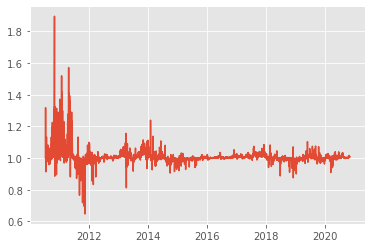

In [92]:
plt.plot(sopr);

In [342]:
adj_sopr = gn.get('https://api.glassnode.com/v1/metrics/indicators/sopr_adjusted', a = 'btc', s='2010', u='2020-11-03')
adj_sopr.to_csv('data/adj_sopr.csv')
print(adj_sopr.shape)
adj_sopr.tail(2)

(3762, 1)


,indicators_sopr_adjusted
t,
2020-11-01,1.043032
2020-11-02,1.047721


In [344]:
lth_sopr = gn.get('https://api.glassnode.com/v1/metrics/indicators/sopr_more_155', a = 'btc', s='2010', u='2020-11-03')
lth_sopr.to_csv('data/lth_sopr.csv')
print(lth_sopr.shape)
lth_sopr.tail(2)

(3240, 1)


,indicators_sopr_more_155
t,
2019-11-04,1.603278
2019-11-05,1.022063


In [345]:
sth_sopr = gn.get('https://api.glassnode.com/v1/metrics/indicators/sopr_less_155', a = 'btc', s='2010', u='2020-11-03')
sth_sopr.to_csv('data/sth_sopr.csv')
print(sth_sopr.shape)
sth_sopr.tail(2)

(3398, 1)


,indicators_sopr_less_155
t,
2019-11-04,1.003646
2019-11-05,0.934256


In [346]:
ntv = gn.get('https://api.glassnode.com/v1/metrics/indicators/nvt', a = 'btc', s='2010', u='2020-11-03')
ntv.to_csv('data/ntv.csv')
print(ntv.shape)
ntv.tail(2)

(3761, 1)


,indicators_nvt
t,
2020-11-01,47.832208
2020-11-02,29.419122


In [347]:
ntvs = gn.get('https://api.glassnode.com/v1/metrics/indicators/nvts', a = 'btc', s='2010', u='2020-11-03')
ntvs.to_csv('data/ntvs.csv')
print(ntvs.shape)
ntvs.tail(2)

(3761, 1)


,indicators_nvts
t,
2020-11-01,40.719971
2020-11-02,40.044418


In [348]:
reserve_risk = gn.get('https://api.glassnode.com/v1/metrics/indicators/reserve_risk', a = 'btc', s='2010', u='2020-11-03')
reserve_risk.to_csv('data/reserve_risk.csv')
print(reserve_risk.shape)
reserve_risk.tail(2)

(3733, 1)


,indicators_reserve_risk
t,
2020-11-01,0.002290
2020-11-02,0.002258


In [349]:
liveliness = gn.get('https://api.glassnode.com/v1/metrics/indicators/liveliness', a = 'btc', s='2010', u='2020-11-03')
liveliness.to_csv('data/liveliness.csv')
print(liveliness.shape)
liveliness.tail(2)

(3959, 1)


,indicators_liveliness
t,
2020-11-01,0.597399
2020-11-02,0.597476


In [350]:
realized_profit = gn.get('https://api.glassnode.com/v1/metrics/indicators/realized_profit', a = 'btc', s='2010', u='2020-11-03')
realized_profit.to_csv('data/realized_profit.csv')
print(realized_profit.shape)
realized_profit.tail(2)

(3762, 1)


,indicators_realized_profit
t,
2020-11-01,2.633819e+08
2020-11-02,3.721412e+08


In [352]:
nupl = gn.get('https://api.glassnode.com/v1/metrics/indicators/net_unrealized_profit_loss', a = 'btc', s='2010', u='2020-11-03')
nupl.to_csv('data/nupl.csv')
print(nupl.shape)
nupl.tail(2)

(3761, 1)


,indicators_net_unrealized_profit_loss
t,
2020-11-01,0.521869
2020-11-02,0.515162


In [353]:
lt_nupl = gn.get('https://api.glassnode.com/v1/metrics/indicators/nupl_more_155', a = 'btc', s='2010', u='2020-11-03')
lt_nupl.to_csv('data/lt_nupl.csv')
print(lt_nupl.shape)
lt_nupl.tail(2)

(3607, 1)


,indicators_nupl_more_155
t,
2020-11-01,0.592573
2020-11-02,0.588429


In [354]:
puell = gn.get('https://api.glassnode.com/v1/metrics/indicators/puell_multiple', a = 'btc', s='2010', u='2020-11-03')
puell.to_csv('data/puell.csv')
print(puell.shape)
puell.tail(2)

(3398, 1)


,indicators_puell_multiple
t,
2020-11-01,0.883858
2020-11-02,0.664141


In [355]:
hodled_lost = gn.get('https://api.glassnode.com/v1/metrics/indicators/hodled_lost_coins', a = 'btc', s='2010', u='2020-11-03')
hodled_lost.to_csv('data/hodled_lost.csv')
print(hodled_lost.shape)
hodled_lost.tail(2)

(3596, 1)


,indicators_hodled_lost_coins
t,
2019-11-04,7.020714e+06
2019-11-05,7.019504e+06


In [356]:
s2f = gn.get('https://api.glassnode.com/v1/metrics/indicators/stock_to_flow_ratio', a = 'btc', s='2010', u='2020-11-03')
s2f.to_csv('data/s2f.csv')
print(s2f.shape)
s2f.tail(2)

(3958, 1)


,o
t,
2020-11-01,"{'daysTillHalving': 1274, 'ratio': 23782.09278..."
2020-11-02,"{'daysTillHalving': 1273, 'ratio': 23964.59587..."


In [365]:
s2f.loc['2020-11-02']

o    {'daysTillHalving': 1273, 'ratio': 23964.59587...
Name: 2020-11-02 00:00:00, dtype: object

In [369]:
s2f['o'][-1]['ratio']

23964.59587474334

In [370]:
ent_adj_sopr = gn.get('https://api.glassnode.com/v1/metrics/indicators/sopr_account_based', a = 'btc', s='2010', u='2020-11-03')
ent_adj_sopr.to_csv('data/ent_adj_sopr.csv')
print(ent_adj_sopr.shape)
ent_adj_sopr.tail(2)

(3398, 1)


,indicators_sopr_account_based
t,
2019-11-04,1.015366
2019-11-05,1.007590


In [371]:
ent_adj_liv = gn.get('https://api.glassnode.com/v1/metrics/indicators/liveliness_account_based', a = 'btc', s='2010', u='2020-11-03')
ent_adj_liv.to_csv('data/ent_adj_liv.csv')
print(ent_adj_liv.shape)
ent_adj_liv.tail(2)

(3596, 1)


,indicators_liveliness_account_based
t,
2019-11-04,0.610421
2019-11-05,0.610409


In [372]:
ent_adj_mvrv = gn.get('https://api.glassnode.com/v1/metrics/indicators/mvrv_account_based', a = 'btc', s='2010', u='2020-11-03')
ent_adj_mvrv.to_csv('data/ent_adj_mvrv.csv')
print(ent_adj_mvrv.shape)
ent_adj_mvrv.tail(2)

(3398, 1)


,indicators_mvrv_account_based
t,
2019-11-04,1.581482
2019-11-05,1.593013


In [373]:
ent_adj_nupl = gn.get('https://api.glassnode.com/v1/metrics/indicators/net_unrealized_profit_loss_account_based', a = 'btc', s='2010', u='2020-11-03')
ent_adj_nupl.to_csv('data/ent_adj_nupl.csv')
print(ent_adj_nupl.shape)
ent_adj_nupl.tail(2)

(3398, 1)


,indicators_net_unrealized_profit_loss_account_based
t,
2019-11-04,0.376605
2019-11-05,0.372797


In [374]:
ent_adj_lth_nupl = gn.get('https://api.glassnode.com/v1/metrics/indicators/nupl_more_155_account_based', a = 'btc', s='2010', u='2020-11-03')
ent_adj_lth_nupl.to_csv('data/ent_adj_lth_nupl.csv')
print(ent_adj_lth_nupl.shape)
ent_adj_lth_nupl.tail(2)

(3398, 1)


,indicators_nupl_more_155_account_based
t,
2019-11-04,0.534799
2019-11-05,0.532703


In [375]:
diff_ribbon = gn.get('https://api.glassnode.com/v1/metrics/indicators/difficulty_ribbon', a = 'btc', s='2010', u='2020-11-03')
diff_ribbon.to_csv('data/diff_ribbon.csv')
print(diff_ribbon.shape)
diff_ribbon.tail(2)

(3959, 1)


,o
t,
2020-11-01,"{'ma128': 76540176425025570000000, 'ma14': 858..."
2020-11-02,"{'ma128': 76681527546396830000000, 'ma14': 858..."


In [376]:
hash_ribbon = gn.get('https://api.glassnode.com/v1/metrics/indicators/hash_ribbon', a = 'btc', s='2010', u='2020-11-03')
hash_ribbon.to_csv('data/hash_ribbon.csv')
print(hash_ribbon.shape)
hash_ribbon.tail(2)

(3959, 1)


,o
t,
2020-11-01,"{'crossed': 0, 'ma30': 132116135061810950000, ..."
2020-11-02,"{'crossed': 0, 'ma30': 130467200605520760000, ..."


In [281]:
total_addresses.merge(active_addresses, left_index = True, right_index = True)

,addresses_count,addresses_active_count
t,,
2010-01-01,32745,4
2010-01-02,32871,0
2010-01-03,33057,0
2010-01-04,33240,85
2010-01-05,33438,0
...,...,...
2020-10-31,728855463,882386
2020-11-01,729280796,891906
2020-11-02,729662935,778647


In [378]:
# merging all files into one dataframe
directoryPath = 'data/'
glued_data = pd.DataFrame()
for file_name in glob.glob(directoryPath+'*.csv'):
    x = pd.read_csv(file_name, low_memory=False)
    glued_data.merge(x, )

In [398]:
combined = glued_data.groupby('t').mean()

In [399]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3961 entries, 2010-01-01 to 2020-11-04
Data columns (total 49 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   market_mvrv_more_155                                 3244 non-null   float64
 1   addresses_accumulation_balance                       3596 non-null   float64
 2   addresses_new_non_zero_count                         3961 non-null   float64
 3   indicators_sopr_account_based                        3398 non-null   float64
 4   indicators_sopr_adjusted                             3604 non-null   float64
 5   transactions_rate                                    3961 non-null   float64
 6   market_mvrv                                          3764 non-null   float64
 7   addresses_accumulation_count                         3596 non-null   float64
 8   entities_receiving_count                             3596 

In [400]:
((combined.isnull().sum())/len(combined)*100).sort_values(ascending = False)

indicators_sopr_more_155                               18.202474
market_mvrv_more_155                                   18.101490
indicators_nupl_more_155_account_based                 14.213582
indicators_sopr_account_based                          14.213582
indicators_puell_multiple                              14.213582
indicators_net_unrealized_profit_loss_account_based    14.213582
indicators_mvrv_account_based                          14.213582
entities_profit_relative                               14.213582
indicators_sopr_less_155                               14.213582
addresses_profit_relative                              14.213582
market_mvrv_less_155                                   14.188336
entities_net_growth_count                               9.214845
entities_receiving_count                                9.214845
addresses_accumulation_balance                          9.214845
transactions_entity_adjusted_count                      9.214845
indicators_liveliness_acc

In [401]:
len(combined.columns)

49

In [403]:
combined.to_csv('data/combined.csv')

a
REQUIRED
string
asset symbol (only: BTC, LTC, BCH)

e
OPTIONAL
string
exchange (see /endpoints)

s
OPTIONAL
integer
since, unix timestamp

u
OPTIONAL
integer
until, unix timestamp

i
OPTIONAL
string
frequency interval, 1h, 10m or 24h (default)

f
OPTIONAL
string
format, csv or json (default)

c
OPTIONAL
string
currency, usd or native (default)

In [402]:
# Coinmetrics

In [405]:
import coinmetrics

In [464]:
# https://github.com/checkmatey/checkonchain/blob/master/general/coinmetrics_api.py
# Import Coinmetrics API
# from checkonchain.general.__init__ import *
import coinmetrics

cm = coinmetrics.Community() # Initialize a reference object, in this case `cm` for the Community API

class Coinmetrics_api:
       
    def __init__(self,asset,begin_timestamp,end_timestamp):
        print('...Fetching Coinmetrics API for '+asset+'...')
        # List all available metrics for BTC.
        self.asset = asset
        self.begin_timestamp=begin_timestamp
        self.end_timestamp=end_timestamp
        self.topcapconst = 35

    def collect_data(self):
        available_data_types = cm.get_available_data_types_for_asset(self.asset)
        metric_list = str((','.join(available_data_types))) #setup complete metric list
        #print(metric_list)
        asset_data = cm.get_asset_data_for_time_range(self.asset, metric_list, self.begin_timestamp, self.end_timestamp)
        return asset_data
    
    def convert_to_pd(self):
        asset_data = Coinmetrics_api.collect_data(self)
        df = coinmetrics.cm_to_pandas(asset_data)
        #Extract Data as column for ease of application
        df.index.name = 'date'
        df.reset_index(inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        #Calc - block height
        df['blk']=df['BlkCnt'].cumsum()
        #Realised Price (Only if present, excludes XMR and ZEC et al.)
        if 'CapRealUSD' in df:
            df['PriceRealUSD'] = df['CapRealUSD']/df['SplyCur']
        #Calc - approx btc block height (Noting BTC blocks were mined from 9/Jan/09)
        df['btc_blk_est'] = (df['date'] - pd.to_datetime(np.datetime64('2009-01-09'),utc=True))
        df['btc_blk_est'] = df['btc_blk_est']/np.timedelta64(1,'D') #convert from timedelta to Days (float)
        df['btc_blk_est'] = df['btc_blk_est']*(24*6) #Note - corrected for neg values in loop below
        #Calc - Daily Issuance
        for i in range(0,len(df.index)):
            #Correct btc_blk_est
            df.loc[i,'btc_blk_est'] = max(0,df.loc[i,'btc_blk_est'])
            if i == 0:
                df.loc[i,'DailyIssuedNtv'] = df.loc[i,'SplyCur']
            else:
                df.loc[i,'DailyIssuedNtv'] = df.loc[i,'SplyCur'] - df.loc[i-1,'SplyCur']
        # Calc - inflation Rate,  S2F, S2F Model, S2F Price
        df['DailyIssuedUSD'] = df['DailyIssuedNtv'] * df['PriceUSD']            
        df['inf_pct_ann'] = df['DailyIssuedNtv']*365/df['SplyCur']
        df['S2F'] = 1/df['inf_pct_ann']     
        df = df.set_index('date')
        df.index = pd.to_datetime(df.index, unit='D')
        df = df.sort_index()
        return df

"""#############################  
    Coinmetrics Community API
BTC = Coinmetrics_api('btc',"2009-01-03","2019-10-07").convert_to_pd()  
################################"""

"""Example Calculations"""
#BTC = Coinmetrics_api('btc',"2009-01-03","2019-10-07").convert_to_pd()
#LTC = Coinmetrics_api('ltc',"2011-10-07",today).convert_to_pd()
#BCH = Coinmetrics_api('bch',"2017-08-01",today).convert_to_pd()
#DASH = Coinmetrics_api('dash',"2014-01-19",today).convert_to_pd()
#DCR = Coinmetrics_api('dcr',"2016-02-08",today).convert_to_pd()
#XMR = Coinmetrics_api('xmr',"2014-04-18",today).convert_to_pd()
#ZEC = Coinmetrics_api('zec',"2016-10-28",today).convert_to_pd()
#ETH = Coinmetrics_api('eth',"2015-07-30",today).convert_to_pd()

"""Time Metrics"""
# date               -datetime64[ns, UTC]
# blk                -ADDED METRIC - block height (Sum of BlkCnt)
# btc_blk_est        -ADDED METRIC - Estimated Bitcoin block-height (Assumes 10min block-times)

"""Blockchain Metrics"""
# AdrActCnt          -Active Addresses
# BlkCnt             -Block Count (Daily)
# BlkSizeByte        -Block Size (Bytes)
# BlkSizeMeanByte    -Block Size Average (Bytes)
# SplyCur            -Current Coin Supply
# inf_pct_ann        -ADDED METRIC - Inflation % annual
# S2F                -ADDED METRIC - Stock-to-Flow Ratio

"""Network Valuation Models"""
# CapMrktCurUSD      - Market Cap
# CapRealUSD         - Realised Cap

"""Network Pricing Models"""
# PriceUSD           - Coin Price USD
# PriceRealised      - Realised Price USD

"""Network Valuation Oscillators"""
# CapMVRVCur         - MVRV Ratio - Market Cap / Realised Cap
# NVTAdj             - NVT Ratio (Adjusted Volume)
# NVTAdj90           - NVT Ratio 90D MA (Adjusted Volume)

"""Transaction Flow Metrics"""
# TxCnt              -Count of Transactions
# TxTfrCnt           -Count of Transaction Transfers (Cleaned Data)
# TxTfrValAdjNtv     -Native Units Transferred (Adjusted Data)
# TxTfrValAdjUSD     -USD Value Transferred (Adjusted Data)
# TxTfrValNtv        -Total Native Units Value Transferred
# TxTfrValUSD        -Total USD Value Transferred
# TxTfrValMeanNtv    -Mean Native Units Transferred
# TxTfrValMeanUSD    -Mean USD Value Transferred
# TxTfrValMedNtv     -Median Native Units Transferred
# TxTfrValMedUSD     -Median USD Value Transferred

"""Miner Metrics"""
# DiffMean          - Average Difficulty
# FeeMeanNtv        - Mean Fee paid in Native Coins (Daily)
# FeeMeanUSD        - Mean Fee paid in USD (Daily)
# FeeMedNtv         - Median Fee paid in Native Coins (Daily)
# FeeMedUSD         - Mean Fee paid in USD (Daily)
# FeeTotNtv         - Total Fees paid in Native Coins (Daily)
# FeeTotUSD         - Total Fees paid in Native Coins (Daily)
# IssContNtv        - Daily Issued Native Coins to Miners/Validators
# IssContPctAnn     - Annualised Inflation Rate
# IssContUSD        - Daily Issued USD to Miners/Validators
# IssTotNtvDaily    - Issued Native Coins to Miners/Validators (Daily)
# IssTotUSD         - Daily Issued USD Value to Miners/Validators (Daily)
# DailyIssuedNtv    - ADDED METRIC - Daily Issued Native Units (Sply_n - Sply_n-1)
# DailyIssuedUSD    - ADDED METRIC - Daily Issued USD Value (Sply_n - Sply_n-1)

"""Market Specific Metrics"""
# ROI1yr
# ROI30d
# VtyDayRet180d
# VtyDayRet30d
# VtyDayRet60d

'Market Specific Metrics'

In [465]:
btc = Coinmetrics_api('btc',"2009-01-03","2020-11-05").convert_to_pd()

...Fetching Coinmetrics API for btc...


In [466]:
btc

,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,...,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,blk,PriceRealUSD,btc_blk_est,DailyIssuedNtv,DailyIssuedUSD,inf_pct_ann,S2F
date,,,,,,,,,,,,,,,,,,,,,
2009-01-03 00:00:00+00:00,0.0,0.0,0.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.000000,NaN,NaN,NaN
2009-01-04 00:00:00+00:00,0.0,0.0,0.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.000000,NaN,NaN,NaN
2009-01-05 00:00:00+00:00,0.0,0.0,0.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.000000,NaN,NaN,NaN
2009-01-06 00:00:00+00:00,0.0,0.0,0.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.000000,NaN,NaN,NaN
2009-01-07 00:00:00+00:00,0.0,0.0,0.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01 00:00:00+00:00,897445.0,125.0,155970614.0,1.247765e+06,2.093168,2.545647e+11,1.216170e+11,1.999734e+13,0.000648,8.900458,...,0.026458,0.018588,0.023757,655062.0,6562.732348,621216.0,781.215161,1.073147e+07,0.015387,64.989910
2020-11-02 00:00:00+00:00,777173.0,95.0,126097116.0,1.327338e+06,2.065861,2.519536e+11,1.219606e+11,1.999734e+13,0.000957,13.007339,...,0.026388,0.018827,0.019009,655157.0,6581.065499,621360.0,593.750000,8.072367e+06,0.011694,85.511966
2020-11-03 00:00:00+00:00,1029970.0,140.0,179259297.0,1.280424e+06,2.094975,2.594037e+11,1.238219e+11,1.775065e+13,0.000858,12.013911,...,0.025889,0.019200,0.019164,655297.0,6681.184082,621504.0,874.999995,1.224730e+07,0.017233,58.028717


In [467]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4325 entries, 2009-01-03 00:00:00+00:00 to 2020-11-05 00:00:00+00:00
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AdrActCnt           4325 non-null   float64
 1   BlkCnt              4325 non-null   float64
 2   BlkSizeByte         4325 non-null   float64
 3   BlkSizeMeanByte     4319 non-null   float64
 4   CapMVRVCur          3764 non-null   float64
 5   CapMrktCurUSD       3764 non-null   float64
 6   CapRealUSD          4325 non-null   float64
 7   DiffMean            4319 non-null   float64
 8   FeeMeanNtv          4067 non-null   float64
 9   FeeMeanUSD          3764 non-null   float64
 10  FeeMedNtv           4067 non-null   float64
 11  FeeMedUSD           3764 non-null   float64
 12  FeeTotNtv           4325 non-null   float64
 13  FeeTotUSD           3764 non-null   float64
 14  HashRate            4319 non-null   float64
 15  IssCont

In [468]:
btc.describe().T

,count,mean,std,min,25%,50%,75%,max
AdrActCnt,4325.0,3.375373e+05,3.304756e+05,0.000000e+00,1.649900e+04,2.211620e+05,6.365650e+05,1.290363e+06
BlkCnt,4325.0,1.515845e+02,3.541973e+01,0.000000e+00,1.380000e+02,1.520000e+02,1.660000e+02,6.920000e+02
BlkSizeByte,4325.0,7.133998e+07,6.576339e+07,0.000000e+00,3.230017e+06,4.869817e+07,1.344669e+08,2.565337e+08
BlkSizeMeanByte,4319.0,4.783265e+05,4.457388e+05,2.150000e+02,2.175124e+04,3.296005e+05,9.231607e+05,1.427240e+06
CapMVRVCur,3764.0,2.031521e+00,3.025572e+00,3.868285e-01,1.239557e+00,1.665712e+00,2.210643e+00,1.460383e+02
CapMrktCurUSD,3764.0,4.819950e+10,6.959284e+10,1.776705e+05,2.681948e+08,6.772236e+09,9.612270e+10,3.288988e+11
CapRealUSD,4325.0,2.583409e+10,3.983097e+10,0.000000e+00,4.296078e+07,4.160805e+09,4.335302e+10,1.253583e+11
DiffMean,4319.0,2.443962e+12,4.822141e+12,1.000000e+00,1.508590e+06,4.000747e+10,1.417073e+12,1.999734e+13
FeeMeanNtv,4067.0,9.258536e-04,7.786785e-03,0.000000e+00,1.380411e-04,2.312954e-04,6.835220e-04,2.200000e-01
FeeMeanUSD,3764.0,1.106191e+00,3.728241e+00,0.000000e+00,3.148392e-02,1.098321e-01,7.353199e-01,5.630812e+01


In [487]:
btc.corr()[['PriceUSD']].sort_values('PriceUSD', ascending = False)

,PriceUSD
PriceUSD,1.000000
CapMrktCurUSD,0.998874
IssTotUSD,0.940451
IssContUSD,0.940451
DailyIssuedUSD,0.940445
PriceRealUSD,0.932047
CapRealUSD,0.929715
TxTfrValAdjUSD,0.896378
TxTfrValMedUSD,0.868140
AdrActCnt,0.814037


In [488]:
abs(btc.corr()[['PriceUSD']]).sort_values('PriceUSD', ascending = False).head(20)

,PriceUSD
PriceUSD,1.000000
CapMrktCurUSD,0.998874
IssTotUSD,0.940451
IssContUSD,0.940451
DailyIssuedUSD,0.940445
PriceRealUSD,0.932047
CapRealUSD,0.929715
TxTfrValAdjUSD,0.896378
TxTfrValMedUSD,0.868140
AdrActCnt,0.814037


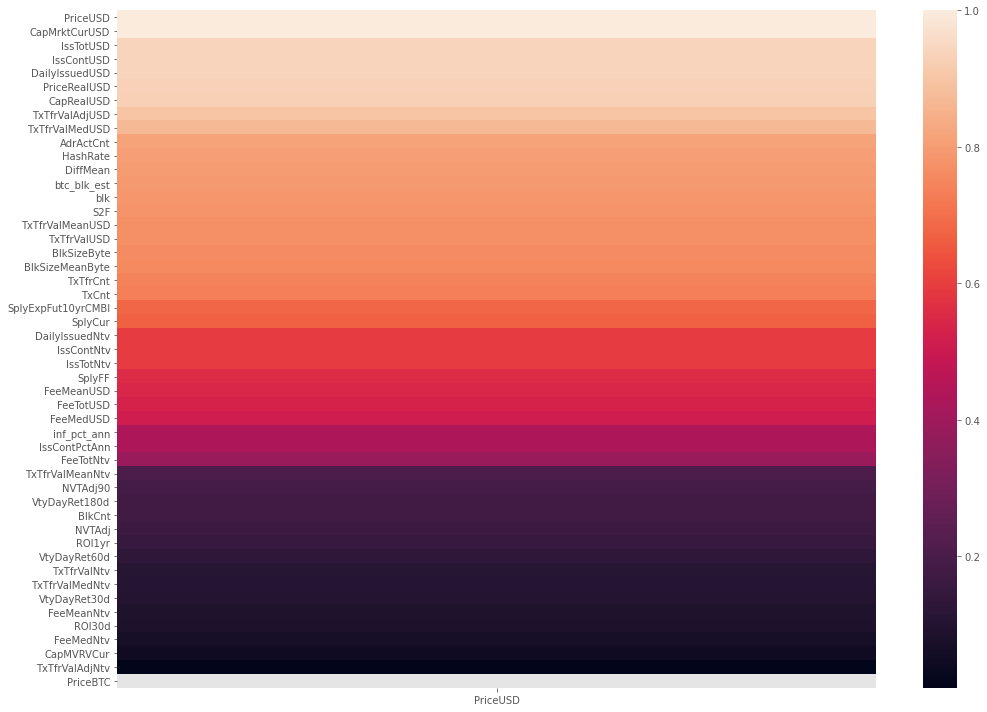

In [502]:
plt.figure(figsize = (15, 10))
sns.heatmap(abs(btc.corr()[['PriceUSD']]).sort_values('PriceUSD', ascending = False))
plt.tight_layout()

In [493]:
"""Time Metrics"""
# date               -datetime64[ns, UTC]
# blk                -ADDED METRIC - block height (Sum of BlkCnt)
# btc_blk_est        -ADDED METRIC - Estimated Bitcoin block-height (Assumes 10min block-times)
time_cols = ['date', 'blk', 'btc_blk_est']

In [424]:
"""Blockchain Metrics"""
# AdrActCnt          -Active Addresses
# BlkCnt             -Block Count (Daily)
# BlkSizeByte        -Block Size (Bytes)
# BlkSizeMeanByte    -Block Size Average (Bytes)
# SplyCur            -Current Coin Supply
# inf_pct_ann        -ADDED METRIC - Inflation % annual
# S2F                -ADDED METRIC - Stock-to-Flow Ratio
blockchain_cols = ['AdrActCnt', 'BlkCnt', 'BlkSizeByte', 'BlkSizeMeanByte', 'SplyCur', 'inf_pct_ann', 'S2F']

In [430]:
"""Network Valuation Models"""
# CapMrktCurUSD      - Market Cap
# CapRealUSD         - Realised Cap
market_val_cols = ['CapMrktCurUSD', 'CapRealUSD', 'Market Cap', 'Realised Cap']

In [431]:
"""Network Pricing Models"""
# PriceUSD           - Coin Price USD
# PriceRealised      - Realised Price USD
market_pricing_cols = ['PriceUSD', 'PriceRealised', 'Coin Price USD', 'Realised Price USD']

In [432]:
"""Network Valuation Oscillators"""
# CapMVRVCur         - MVRV Ratio - Market Cap / Realised Cap
# NVTAdj             - NVT Ratio (Adjusted Volume)
# NVTAdj90           - NVT Ratio 90D MA (Adjusted Volume)
market_oscil_cols = ['CapMVRVCur', 'NVTAdj', 'NVTAdj90', 'MVRV Ratio - Market Cap / Realised Cap', 
                      'NVT Ratio (Adjusted Volume)', 'NVT Ratio 90D MA (Adjusted Volume)']

In [428]:
"""Transaction Flow Metrics"""
# TxCnt              -Count of Transactions
# TxTfrCnt           -Count of Transaction Transfers (Cleaned Data)
# TxTfrValAdjNtv     -Native Units Transferred (Adjusted Data)
# TxTfrValAdjUSD     -USD Value Transferred (Adjusted Data)
# TxTfrValNtv        -Total Native Units Value Transferred
# TxTfrValUSD        -Total USD Value Transferred
# TxTfrValMeanNtv    -Mean Native Units Transferred
# TxTfrValMeanUSD    -Mean USD Value Transferred
# TxTfrValMedNtv     -Median Native Units Transferred
# TxTfrValMedUSD     -Median USD Value Transferred
transaction_cols = ['TxCnt', 'TxTfrCnt', 'TxTfrValAdjNtv', 'TxTfrValAdjUSD', 'TxTfrValNtv', 'TxTfrValUSD', 
                    'TxTfrValMeanNtv', 'TxTfrValMeanUSD' ,'TxTfrValMedNtv', 'TxTfrValMedUSD']

In [429]:
"""Miner Metrics"""
# DiffMean          - Average Difficulty
# FeeMeanNtv        - Mean Fee paid in Native Coins (Daily)
# FeeMeanUSD        - Mean Fee paid in USD (Daily)
# FeeMedNtv         - Median Fee paid in Native Coins (Daily)
# FeeMedUSD         - Mean Fee paid in USD (Daily)
# FeeTotNtv         - Total Fees paid in Native Coins (Daily)
# FeeTotUSD         - Total Fees paid in Native Coins (Daily)
# IssContNtv        - Daily Issued Native Coins to Miners/Validators
# IssContPctAnn     - Annualised Inflation Rate
# IssContUSD        - Daily Issued USD to Miners/Validators
# IssTotNtvDaily    - Issued Native Coins to Miners/Validators (Daily)
# IssTotUSD         - Daily Issued USD Value to Miners/Validators (Daily)
# DailyIssuedNtv    - ADDED METRIC - Daily Issued Native Units (Sply_n - Sply_n-1)
# DailyIssuedUSD    - ADDED METRIC - Daily Issued USD Value (Sply_n - Sply_n-1)
miner_cols = ['DiffMean', 'FeeMeanNtv', 'FeeMeanUSD', 'FeeMedNtv', 'FeeMedUSD', 'FeeTotNtv', 'FeeTotUSD',
              'IssContNtv', 'IssContPctAnn', 'IssContUSD', 'IssTotNtvDaily', 'IssTotUSD' ,'DailyIssuedNtv', 
              'DailyIssuedUSD']

In [433]:
"""Market Specific Metrics"""
# ROI1yr
# ROI30d
# VtyDayRet180d
# VtyDayRet30d
# VtyDayRet60d
market_metrics_cols = ['ROI1yr', 'ROI30d', 'VtyDayRet180d', 'VtyDayRet30d', 'VtyDayRet60d']